## Import Packages

In [1]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

import math
import torch
from matplotlib import pyplot as plt
%matplotlib inline

import re
import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

## Prepare Data

In [5]:
#read in features
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
data_path = 'data/harpoon/harpoon-doe.xlsx'
df_x = pd.read_excel(data_path,sheet_name = 0, usecols = [1,2,3,4])
df_x.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_x.columns]
#print(len(df_x))
#df_x.head()

In [6]:
#read in targets
df_y_1 = pd.read_excel(data_path,sheet_name = 1, usecols = [1,4,7],skiprows = lambda x: x in [1])
df_y_1.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_y_1.columns]
#print(len(df_y_1))
#print(df_y_1.head())

df_y_2 = pd.read_excel(data_path,sheet_name = 1, usecols = [2,5,8],skiprows = lambda x: x in [1])
df_y_2.columns = df_y_1.columns
#print(len(df_y_2))
#print(df_y_2.head())

df_y_3 = pd.read_excel(data_path,sheet_name = 1, usecols = [3,6,9],skiprows = lambda x: x in [1])
df_y_3.columns = df_y_1.columns
#print(len(df_y_3))
#print(df_y_3.head())



In [7]:
cols_feature01 = list(df_x.columns)
cols_target = list(df_y_1.columns)[0:2]
#cols_target = list(df_y_1.columns)
cols_cate = ['Buffer_Type',
 'Sugar_Salt',
 'Additive']

In [8]:
total_df_y_long = pd.concat((df_y_1[cols_target],df_y_2[cols_target],df_y_3[cols_target]),axis = 0)
total_df_y_long.reset_index(inplace = True, drop = True)
total_df_y_long

,_Dimer_HMW_,_Monomer
0,2.4,95.1
1,0.8,97.3
2,3.2,94.3
3,1.4,96.7
4,4.2,93.3
...,...,...
67,3.3,92.3
68,3.7,92.3
69,3.6,92.2
70,4.2,90.8


In [9]:
df_y_1.columns = [c+'_1' for c in df_y_1.columns]
df_y_2.columns = [c+'_2' for c in df_y_2.columns]
df_y_3.columns = [c+'_3' for c in df_y_3.columns]

In [10]:
cols_target_new = ['_Dimer_HMW_1', '_Monomer_1',
       '_Dimer_HMW_2', '_Monomer_2', 
       '_Dimer_HMW_3','_Monomer_3']

arr_Y = np.concatenate((df_y_1.to_numpy()[:,:2],
                            df_y_2.to_numpy()[:,:2],
                            df_y_3.to_numpy()[:,:2]),axis = 1)
total_df_y_wide = pd.DataFrame(arr_Y,columns= cols_target_new)


In [11]:
#convert categorical columns to labels
for x_name in cols_cate:
    labels, categories = factorize(df_x[x_name])
    df_x[x_name+"_label"] = labels
df_x.drop(cols_cate,axis = 1,inplace = True)
display(df_x.head())

,pH,Buffer_Type_label,Sugar_Salt_label,Additive_label
0,4.5,0,0,0
1,4.5,0,0,1
2,5.0,0,0,0
3,5.0,0,0,1
4,5.0,0,1,1


In [12]:
ls_model = ['simpleGP','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust']
ls_cate_transform = ['label','ohe','LVGP','full-LMGP','partial-LMGP']
ls_remove_pred_outlier = [0,1]
ls_output_rank_option = [1,2]
ls_task_rank_option = [1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_split_option = ['mix','separate'] #mix: combine all tasks first then do train, test split (could stratify task?) #separate, do train-test-split first, then combine tasks
ls_stratify_task = ['not-stratify','stratify-x','stratify-y','stratify-xy']


model_option = 'multi-task-multi-output'
multi_task_label = 'hier'

x_scale_option = 'x-minmax'
y_scale_option = 'general-y-stand' #'bytask-y-stand'
cate_transform_option = 'partial-LMGP'
#remove_pred_outlier_option= 0

output_rank_option = 2 #if 0, no correlation between output
task_rank_option = 3#if 0, no correlation between tasks
lik_rank_option = 1
split_option = 'mix'
stratify_option = 'stratify-x'

noise_option = 0 #noise percentage

model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_transform_label = 'cate_transform_'+cate_transform_option
#remove_pred_outlier_label = 'remove_pred_outlier_'+str(remove_pred_outlier_option)
output_rank_label = 'output_rank_'+str(output_rank_option)
task_rank_label = 'task_rank_'+str(task_rank_option)
lik_rank_label = 'lik_rank_'+str(lik_rank_option)
split_label = split_option
stratify_label = stratify_option
if noise_option>0:
        noise_label = 'noise_'+str(noise_option)
else:
        noise_label = ''

folder_name = '-'.join([model_label,task_rank_label,output_rank_label,lik_rank_label,x_scale_label,y_scale_label,cate_transform_label,
                        split_label,stratify_label,noise_label])

figPath = 'output/harpoon-lmgp-adapt-jan2026/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

Creating folder output/harpoon-lmgp-adapt-jan2026/multi-task-multi-output-task_rank_3-output_rank_2-lik_rank_1-x-minmax-general-y-stand-cate_transform_partial-LMGP-mix-stratify-x-


In [13]:
if split_label == 'mix':
    ls_X = [df_x.copy(),
            df_x.copy(),
            df_x.copy()]
    
    for i,tmp_df_x in enumerate(ls_X):
        tmp_df_x['task_ind'] = i

    df_X = pd.concat(ls_X)
    df_X.reset_index(inplace=True, drop = True)
    #print(df_X.head())

In [14]:
#add noisy data to datasets
np.random.seed(42)
N = len(df_X)

if noise_option>0:
#create data with noise
    df_X_syn = df_X.copy()
    for col in df_X.columns.difference(['task_ind']):
        df_X_syn[col] = df_X_syn[col] + np.random.normal(0, df_X_syn[col].std(), N) * noise_option

    df_Y_syn= total_df_y_long[cols_target].copy()
    for col in cols_target:
        df_Y_syn[col] = df_Y_syn[col] + np.random.normal(0, df_Y_syn[col].std(), N) * noise_option

if noise_option>0:
    df_total_X = pd.concat((df_X,df_X_syn))
    df_total_Y = pd.concat((total_df_y_long[cols_target],df_Y_syn))
else:
    df_total_X = df_X
    df_total_Y = total_df_y_long

In [15]:
"""
from sklearn.cluster import KMeans
ls_n_clusters = [4,2,2]
for i,x_name in enumerate(['Buffer_Type_label','Sugar_Salt_label','Additive_label']):
    best_n_clusters = ls_n_clusters[i]
    km = KMeans(n_clusters=best_n_clusters, random_state=10)
    kmeans = km.fit(df_total_X[[x_name]])
    df_total_X[x_name] = kmeans.labels_
"""
if multi_task_label == 'hier':
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_total_X, df_total_Y, test_size=0.2, 
                                                                random_state=0, 
                                                                stratify=df_total_X['task_ind'])

else:
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_total_X, df_total_Y, test_size=0.2, 
                                                                random_state=0)

In [16]:
#preprocessing features
xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),
                          df_X_train.columns.difference(['Buffer_Type_label','Sugar_Salt_label','Additive_label','task_ind']))], 
                         remainder = 'passthrough')

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)

t_train_x = torch.Tensor(scaled_X_train)
t_test_x = torch.Tensor(scaled_X_test)

In [17]:
df_X_train.columns

Index(['pH', 'Buffer_Type_label', 'Sugar_Salt_label', 'Additive_label',
       'task_ind'],
      dtype='object')

In [18]:
qual_ind_lev = {1: 4, 2:2, 3:2} #2nd, 3rd, and 4th columns are categorical vars. col index: number of levels
quant_index = [0]#1st column is continous var
task_index = 4#fifth column is task column
num_tasks = 3

In [19]:
#scale targets

scaled_y_train = np.zeros_like(df_y_train.to_numpy())
scaled_y_test = np.zeros_like(df_y_test.to_numpy())
ls_y_task_scaler = []
ls_row_idx_train = []
ls_row_idx_test = []

if y_scale_label == 'y-robust':
    y_scaler = RobustScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'general-y-stand':
    y_scaler = StandardScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'bytask-y-stand':
    for task_ind in range(num_tasks):
        y_task_scaler = StandardScaler()
        row_idx_train = np.where(df_X_train['task_ind']==task_ind)[0]
        ls_row_idx_train.append(row_idx_train)
        row_idx_test = np.where(df_X_test['task_ind']==task_ind)[0]
        ls_row_idx_test.append(row_idx_test)
        scaled_y_train_task =y_task_scaler.fit_transform(df_y_train[df_X_train['task_ind']==task_ind])
        scaled_y_test_task= y_task_scaler.transform(df_y_test[df_X_test['task_ind']==task_ind])
        ls_y_task_scaler.append(y_task_scaler)
        scaled_y_train[row_idx_train] = scaled_y_train_task
        scaled_y_test[row_idx_test] = scaled_y_test_task
elif y_scale_label == 'y-minmax':
    y_scaler = MinMaxScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
else:
    scaled_y_train = df_y_train.to_numpy()
    scaled_y_test = df_y_test.to_numpy()

t_train_y = torch.Tensor(scaled_y_train)

In [20]:
#calculate correlations between two outputs
pd.DataFrame(t_train_y.numpy()).corr()

,0,1
0,1.000000,-0.857071
1,-0.857071,1.000000


## Define GP

In [21]:
import gpytorch
from gpytorch.priors import NormalPrior,LogNormalPrior,SmoothedBoxPrior,HorseshoePrior
from gpytorch.constraints import GreaterThan,Positive


from torch import nn
import torch.nn.functional as F

from typing import Dict,List,Optional
from copy import deepcopy
from tqdm import tqdm

In [22]:
## Basic MTMO class

class MultiOutputMultiTaskGP(gpytorch.models.ExactGP):

    def __init__(
        self,
        train_X,
        train_Y,
        data_kernel,
        noise_indices,
        fix_noise:bool=False,
        lb_noise:float=1e-4,
        task_rank = None,
        output_rank = None,
        lik_rank = None
    ) -> None:

        num_outputs = train_Y.shape[-1]
        num_tasks = len(torch.unique(train_X[..., -1]))
        self._num_tasks = num_tasks
        self._num_outputs = num_outputs
        
        self.task_rank = task_rank if task_rank is not None else num_tasks
        self.output_rank = output_rank if output_rank is not None else num_outputs
        self.lik_rank = lik_rank if lik_rank is not None else 0
        # initializing likelihood
        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs,rank = self.lik_rank)
        super(MultiOutputMultiTaskGP, self).__init__(train_X, train_Y,likelihood)

        self.likelihood.register_prior('raw_noise_prior',HorseshoePrior(0.01,lb_noise),'raw_noise')
        if self.lik_rank == 0:
            self.likelihood.register_prior('raw_task_noises_prior',HorseshoePrior(0.01,lb_noise),'raw_task_noises')    
        else:
            self.likelihood.register_prior('task_noise_covar_factor_prior',NormalPrior(0.,1),'task_noise_covar_factor')

        if fix_noise:
            self.likelihood.raw_noise.requires_grad_(False)
            self.likelihood.noise_covar.noise =torch.tensor(4.9901e-05)

        
        #define prior for mean module
        mean_list = [gpytorch.means.ConstantMean(NormalPrior(0,1)) for t in range(num_outputs)]
        self.mean_module = gpytorch.means.MultitaskMean(
            mean_list, num_tasks=num_outputs
        )
        
        self.data_kernel = data_kernel
        
        
        if not isinstance(data_kernel,gpytorch.kernels.Kernel):
            raise RuntimeError(
                "specified data kernel is not a `gpytorch.kernels.Kernel` instance"
            )

        #define kernel for gplvm on mixed variables
        self.data_kernel2 = gpytorch.kernels.RBFKernel()
        self.data_kernel2.register_prior(
                    'lengthscale_prior',SmoothedBoxPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                )

        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank = self.task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_outputs, rank = self.output_rank) #default rank is 1
        
        self.task_kernel.register_prior("covar_factor_prior",NormalPrior(0.,1),lambda m: m._parameters['covar_factor'])
        self.task_kernel.register_prior("raw_var_prior",NormalPrior(0.,1),lambda m: m._parameters['raw_var'])

        self.output_kernel.register_prior("covar_factor_prior",NormalPrior(0.,1),lambda m: m._parameters['covar_factor'])
        self.output_kernel.register_prior("raw_var_prior",NormalPrior(0.,1),lambda m: m._parameters['raw_var'])
        
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
    def predict(
        self,x:torch.Tensor,return_std:bool=False,include_noise:bool=False
    ):

        self.eval()
        self.likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred_res = self.likelihood(self.forward(x))   
            mean = pred_res.mean
            lower, upper = pred_res.confidence_region()
        return mean, lower, upper

In [23]:
## optimization function using torch
def fit_model_torch(
    model,
    model_param_groups:Optional[List]=None,
    lr_default:float=0.01,
    num_iter:int=100,
    num_restarts:int=0,
    break_steps:int = 50) -> float:
    '''Optimize the likelihood/posterior of a standard GP model using `torch.optim.Adam`.

    :param model: A model instance derived from the `models.GPR` class.
    :type model: models.GPR

    :param model_param_groups: list of parameters to optimizes or dicts defining parameter
        groups. If `None` is specified, then all parameters with `.requires_grad`=`True` are 
        included. Defaults to `None`.
    :type model_param_groups: list, optional

    :param lr_default: The default learning rate for all parameter groups. To use different 
        learning rates for some groups, specify them `model_param_groups`. 
    :type lr_default: float, optional

    :param num_iter: The number of optimization steps from each starting point. This is the only
        termination criterion for the optimizer.
    :type num_iter: float, optional

    :param num_restarts: The number of times to restart the local optimization from a 
        new starting point. Defaults to 5
    :type num_restarts: int, optional

    :returns: the best (negative) log-likelihood/log-posterior found
    :rtype: float
    '''  
    model.train()
    
    # objective
    #mll = ExactMarginalLogLikelihood(model.likelihood, model)
    
    
    f_inc = math.inf
    current_state_dict = model.state_dict()


    loss_hist_total = []

    for i in range(num_restarts+1):
        optimizer = torch.optim.Adam(
            model.parameters() if model_param_groups is None else model_param_groups, 
            lr=lr_default)
        loss_hist = []
        epochs_iter = tqdm(range(num_iter),desc='Epoch',position=0,leave=True)
        for j in epochs_iter:
            # zero gradients from previous iteration
            optimizer.zero_grad()
            # output from model
            output = model(*model.train_inputs)
            # calculate loss and backprop gradients
            #loss = -mll(output,model.train_targets)
            loss = -model.likelihood(output).log_prob(model.train_targets)
            loss.backward()
            optimizer.step()

            acc_loss = loss.item()
            desc = f'Epoch {j} - loss {acc_loss:.4f}'
            epochs_iter.set_description(desc)
            epochs_iter.update(1)
            loss_hist.append(acc_loss)

            if j > break_steps and j%break_steps == 0:
                if ( (torch.mean(torch.Tensor(loss_hist)[j-break_steps:j]) - loss_hist[j]) <= 0 ):
                    break
        
        loss_hist_total.append(loss_hist)

        if loss.item()<f_inc:
            current_state_dict = deepcopy(model.state_dict())
            f_inc = loss.item()
    
    model.load_state_dict(current_state_dict)

    return f_inc, loss_hist_total

In [24]:
############################################
class Linear_MAP(nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
        super().__init__(in_features, out_features, bias, device, dtype)
        
    def forward(self, input, transform = lambda x: x):
        return F.linear(input,transform(self.weight), self.bias)

######################################################################## GPLVM  #####################################################
class GPLVM(nn.Module):
    def __init__(self, GP_Lmgp, input_size, num_classes, name):
        super(GPLVM, self).__init__()
        
        self.gplvm = Linear_MAP(input_size, num_classes, bias = False)
        GP_Lmgp.register_parameter(name, self.gplvm.weight)
        GP_Lmgp.register_prior(name = 'gplvm_prior_'+name, prior=gpytorch.priors.NormalPrior(0,1) , param_or_closure=name)

    def forward(self, x, transform = lambda x: x):
        x = self.gplvm(x, transform)
        return x


######################################################################## LMGP  #####################################################
class LMGP(nn.Module):
    def __init__(self, GP_Lmgp, input_size, num_classes,name):
        super(LMGP, self).__init__()
        
        
        self.fci = Linear_MAP(input_size, num_classes, bias = False)
        GP_Lmgp.register_parameter(name, self.fci.weight)
        GP_Lmgp.register_prior(name = 'latent_prior_'+name, prior=gpytorch.priors.NormalPrior(0,1) , param_or_closure=name)

    def forward(self, x, transform = lambda x: x):
        x = self.fci(x, transform)
        return x

In [25]:
##inporating LMGP into GPR
class GP_Lmgp(MultiOutputMultiTaskGP):
    """The GP_Lmgp extends GPs to handle categorical inputs

    :note: Binary categorical variables should not be treated as qualitative inputs. There is no 
        benefit from applying a latent variable treatment for such variables. Instead, treat them
        as numerical inputs.

    :param train_x: The training inputs (size N x d). Qualitative inputs needed to be encoded as 
        integers 0,...,L-1 where L is the number of levels. For best performance, scale the 
        numerical variables to the unit hypercube.
    """
    def __init__(
        self,
        train_x:torch.Tensor,
        train_y:torch.Tensor,
        quant_correlation_class:str='RBFKernel',
        my_nu = 2.5, #nu for MaternKernel
        qual_ind_lev = {},
        quant_index = [],
        task_index = -1,
        multiple_noise = False,
        lv_dim:int=2,
        fix_noise:bool=False,
        fixed_length_scale:bool=False,
        fixed_omega=torch.tensor([1.0]),
        lb_noise:float=1e-4,
        encoding_type = 'one-hot',
        uniform_encoding_columns = 2,
        lv_columns = [] ,
        base='single_constant',
        seed_number=1,
        device="cpu",
        dtype= torch.float,
        is_mix_reduce = False,
        task_rank=None,
        output_rank = None,
        lik_rank=None
    ) -> None:
        
        tkwargs = {}  # or dict()
        tkwargs['dtype'] = dtype
        tkwargs['device'] =torch.device(device)
        self.tkwargs=tkwargs

        if fixed_length_scale:
            self.fixed_omega=fixed_omega.to(**self.tkwargs)
        else:
            self.fixed_omega=None

        
        train_x=self.fill_nan_with_mean(train_x)
        ###############################################################################################
        ###############################################################################################
        self.seed=seed_number
        self.calibration_source_index=0    ## It is supposed the calibration parameter is for high fidelity needs
        qual_index = list(qual_ind_lev.keys())
        all_index = set(range(train_x.shape[-1]))
        #quant_index = list(all_index.difference(qual_index))
        num_levels_per_var = list(qual_ind_lev.values())
        #------------------- lm columns --------------------------
        lm_columns = list(set(qual_index).difference(lv_columns))
        if len(lm_columns) > 0:
            qual_kernel_columns = [*lv_columns, lm_columns]
        else:
            qual_kernel_columns = lv_columns
        #########################
        if len(qual_index) > 0:
            train_x = torch.tensor(train_x)#.to(**self.tkwargs)
        #
        train_x=train_x.to(**self.tkwargs)
        train_y=train_y.to(**self.tkwargs)
        #train_y=train_y.reshape(-1)#.to(**self.tkwargs)
        
        if multiple_noise:
            noise_indices = list(range(0,num_levels_per_var[-1]))
        else:
            noise_indices = []

        if len(qual_index) == 1 and num_levels_per_var[0] < 2:
            temp = quant_index.copy()
            temp.append(qual_index[0])
            quant_index = temp.copy()
            qual_index = []
            lv_dim = 0
        elif len(qual_index) == 0:
            lv_dim = 0

        quant_correlation_class_name = quant_correlation_class

        if len(qual_index) == 0:
            lv_dim = 0
    

        if len(qual_index) > 0:
            ####################### Defined multiple kernels for seperate variables ###################
            qual_kernels = []
            for i in range(len(qual_kernel_columns)):
                qual_kernels.append(gpytorch.kernels.RBFKernel(
                    active_dims=torch.arange(lv_dim) + lv_dim * i) )
                #qual_kernels[i].initialize(**{'lengthscale':1.0})
                #qual_kernels[i].raw_lengthscale.requires_grad_(False)  
            qual_kernels[0].register_prior(
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )

        if len(quant_index) == 0:
            print('---no numerical columns----')
            correlation_kernel = qual_kernels[0]
            for i in range(1, len(qual_kernels)):
                correlation_kernel *= qual_kernels[i]
        else:
            try:
                quant_correlation_class = getattr(gpytorch.kernels,quant_correlation_class)
            except:
                raise RuntimeError(
                    "%s not an allowed kernel" % quant_correlation_class
                )
            if quant_correlation_class_name == 'RBFKernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns) * lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)
                )
            
            elif quant_correlation_class_name == 'MaternKernel':
                quant_kernel = quant_correlation_class(
                    nu = my_nu,
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))
                )
                #####################
            
            if quant_correlation_class_name == 'RBFKernel':
                quant_kernel.register_prior(
                    'lengthscale_prior', SmoothedBoxPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                )
                
            elif quant_correlation_class_name == 'MaternKernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', SmoothedBoxPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )
            
            #########Product between qual kernels and quant kernels############
            if len(qual_index) > 0:
                temp = qual_kernels[0]
                for i in range(1, len(qual_kernels)):
                    temp *= qual_kernels[i]
                correlation_kernel = temp*quant_kernel #+ qual_kernel + quant_kernel
            else:
                correlation_kernel = quant_kernel
            
        
        super(GP_Lmgp,self).__init__(
            train_X=train_x,train_Y=train_y,noise_indices=noise_indices,
            data_kernel=correlation_kernel,
            fix_noise=fix_noise,lb_noise=lb_noise,
            task_rank= task_rank, output_rank = output_rank, lik_rank = lik_rank
        )
        
        # register index and transforms
        self.register_buffer('quant_index',torch.tensor(quant_index))
        self.register_buffer('qual_index',torch.tensor(qual_index))

        self.quant_kernel = quant_kernel
        self.correlation_kernel = correlation_kernel
        self.qual_kernels = qual_kernels
        
        self.qual_kernel_columns = qual_kernel_columns
        self.is_mix_reduce = is_mix_reduce
        ######################## latent variable mapping  ########################
        self.num_levels_per_var = num_levels_per_var
        self.lv_dim = lv_dim
        self.uniform_encoding_columns = uniform_encoding_columns
        self.encoding_type = encoding_type
        self.perm =[]
        self.zeta = []
        self.random_zeta=[]
        self.perm_dict = []
        self.A_matrix = []
        
        self.epsilon=None
        self.epsilon_f=None
        self.embeddings_Dtrain=[]
        self.count=train_x.size()[0]
        if len(qual_kernel_columns) > 0:
            for i in range(len(qual_kernel_columns)):
                if type(qual_kernel_columns[i]) == int:
                    num = self.num_levels_per_var[qual_index.index(qual_kernel_columns[i])]
                    cat = [num]
                else:
                    cat = [self.num_levels_per_var[qual_index.index(k)] for k in qual_kernel_columns[i]]
                    num = sum(cat)

                zeta, perm, perm_dict = self.zeta_matrix(num_levels=cat, lv_dim = self.lv_dim)
                self.zeta.append(zeta)
                self.perm.append(perm)
                self.perm_dict.append(perm_dict)       
                ###################################  latent map #################################   
                model_lmgp = LMGP(self, input_size= num, num_classes=lv_dim, 
                        name ='latent'+ str(qual_kernel_columns[i])).to(**self.tkwargs)
                self.A_matrix.append(model_lmgp)
        ######## GPLVM transformation if there are quantitative variables########################
        
        if is_mix_reduce and len(quant_index) > 0:
            dim_x_new = self.lv_dim+len(quant_index)
            self.W_matrix= GPLVM(self, input_size=  dim_x_new, num_classes=lv_dim, 
                        name ='gplvm'+ str(dim_x_new)).to(**self.tkwargs)
        
        ##################################################################################
        if fixed_length_scale == True:
            self.covar_module.base_kernel.raw_lengthscale.data = self.fixed_omega #torch.tensor([self.omega, self.omega])  # Set the desired value
            self.covar_module.base_kernel.raw_lengthscale.requires_grad = False  # Fix the hyperparameter
        ###################################  Mean Function #################################   
        #i=0
        self.base=base
        self.num_sources=int(torch.max(train_x[:,-1]))
        size=train_x.shape[1]
        self.single_base_register(size,base_type=self.base,wm='mean_module')



    def forward(self,x:torch.Tensor):
        
        Numper_of_pass=1
        
        size_sigma_sum = x.size(0)*self._num_outputs
        #size_sigma_sum = x.size(0)
        Sigma_sum=torch.zeros(size_sigma_sum,size_sigma_sum, dtype=torch.float64).to(self.tkwargs['device'])
        
        mean_x_sum=torch.zeros(x.size(0),self._num_outputs, dtype=torch.float64).to(self.tkwargs['device'])
        #print('mean_x_sum.shape',mean_x_sum.shape)
        task_term = self.task_kernel(x[..., -1].long())

        for NP in range(Numper_of_pass):
            x_forward_raw=x[..., :-1].clone()
            nd_flag = 0
            if x.dim() > 2:
                xsize = x.shape
                x = x.reshape(-1, x.shape[-1])
                nd_flag = 1
            
            x_new= x
            x_gplvm = x
            if len(self.qual_kernel_columns) > 0:
                embeddings = []
                for i in range(len(self.qual_kernel_columns)):
                    temp= self.transform_categorical(x=x[:,self.qual_kernel_columns[i]].clone().type(torch.int64).to(self.tkwargs['device']), 
                        perm_dict = self.perm_dict[i], zeta = self.zeta[i])
                dimm=x_forward_raw.size()[0]
                
                embeddings.append(self.A_matrix[i](temp.float().to(**self.tkwargs)))
                x_new= torch.cat([embeddings[0],x[...,self.quant_index.long()].to(**self.tkwargs)],dim=-1)
                #print('x_new.shape after reduce cate',x_new.shape)
            
            if self.is_mix_reduce and len(self.quant_index) > 0:
                x_gplvm = self.W_matrix(x_new.float().to(**self.tkwargs))
                #print('x_gplvm.shape after reduce all',x_gplvm.shape)
                #x_new = x_gplvm
            
            if nd_flag == 1:
                x_new = x_new.reshape(*xsize[:-1], -1)
            
        #################### Multiple baises (General Case) ####################################  
            
            if self.is_mix_reduce and len(self.quant_index) > 0:
                    mean_x = self.mean_module(x_gplvm).to(**self.tkwargs)
            else:
                    mean_x = self.mean_module(x_new).to(**self.tkwargs)
            
            #data_kernel is a product kernel of cate kernel and quant kernel
            data_and_task_x = self.data_kernel(x_new).mul(task_term)
            output_x = self.output_kernel.covar_matrix
            covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)

            if self.is_mix_reduce and len(self.quant_index) > 0:
                #data_kernel2 is one kernel for both cate and quant variables
                data_and_task_x_gplvm = self.data_kernel2(x_gplvm).mul(task_term)
                covar_x_mixed = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x_gplvm, output_x)
                covar_x = covar_x.mul(covar_x_mixed)

            mean_x_sum+=mean_x
            
            Sigma_sum += covar_x.evaluate()

        # End of the loop for forward pasess ----> Compute ensemble mean and covariance
        k = Numper_of_pass
        ensemble_mean = mean_x_sum/k
        ensemble_covar = torch.zeros_like(Sigma_sum) 
        ensemble_covar= Sigma_sum/k
        ensemble_covar=gpytorch.lazy.NonLazyTensor(ensemble_covar)
        Sigma_sum=0
        #print('ensemble_mean.shape',ensemble_mean.shape)
        #print('ensemble_covar.shape',ensemble_covar.evaluate().shape)

        return gpytorch.distributions.MultitaskMultivariateNormal(ensemble_mean.float(),ensemble_covar.float())
    
    ################################################################ Mean Functions #####################################################################################
    
    def single_base_register(self,size=1,base_type='single_zero',wm='mean_module'):
        if base_type=='single_constant':
            #mean_list = [gpytorch.means.ConstantMean(NormalPrior(0.,1)) for t in range(self._num_tasks)]
            setattr(self,wm, self.mean_module)
        elif base_type=='single_zero':
            setattr(self,wm, gpytorch.means.ZeroMean()) 

    ################################################################ Fit #####################################################################################
    def fit(self,add_prior:bool=True,num_restarts:int=64,theta0_list:Optional[List[np.ndarray]]=None,jac:bool=True,
            options:Dict={},n_jobs:int=-1,method = 'L-BFGS-B',constraint=False,bounds=False,regularization_parameter:List[int]=[0,0],optim_type='scipy'):
        print("## Learning the model's parameters has started ##")
        #optim_type=='adam_torch':
        fit_model_torch(model=self,
                    model_param_groups=None,
                    lr_default=0.01,
                    num_iter=100,
                    num_restarts=num_restarts,
                    break_steps= 50)
        
        print("## Learning the model's parameters is successfully finished ##")




    def fill_nan_with_mean(self,train_x):
        # Check if there are any NaNs in the tensor
        if torch.isnan(train_x).any():
            # Compute the mean of non-NaN elements column-wise
            col_means = torch.nanmean(train_x, dim=0)
            # Find indices where NaNs are located
            nan_indices = torch.isnan(train_x)
            # Replace NaNs with the corresponding column-wise mean
            train_x[nan_indices] = col_means.repeat(train_x.shape[0], 1)[nan_indices]

        return train_x
    ############################  Prediction and Visualization  ###############################
    
    def predict(self, Xtest,return_std=True, include_noise = True):
        with torch.no_grad():
            return super().predict(Xtest, return_std = return_std, include_noise= include_noise)
    
    def predict_with_grad(self, Xtest,return_std=True, include_noise = True):
        return super().predict(Xtest, return_std = return_std, include_noise= include_noise)
    
    @classmethod
    def show(cls):
        plt.show()
        
    def get_params(self, name = None):
        params = {}
        print('###################Parameters###########################')
        for n, value in self.named_parameters():
             params[n] = value
        if name is None:
            print(params)
            return params
        else:
            if name == 'Mean':
                key = 'mean_module.constant'
            elif name == 'Sigma':
                key = 'covar_module.raw_outputscale'
            elif name == 'Noise':
                key = 'likelihood.noise_covar.raw_noise'
            elif name == 'Omega':
                for n in params.keys():
                    if 'raw_lengthscale' in n and params[n].numel() > 1:
                        key = n
            print(params[key])
            return params[key]

    def zeta_matrix(self,
        num_levels:int,
        lv_dim:int,
        batch_shape=torch.Size()
    ) -> None:

        if any([i == 1 for i in num_levels]):
            raise ValueError('Categorical variable has only one level!')

        if lv_dim == 1:
            raise RuntimeWarning('1D latent variables are difficult to optimize!')
        
        for level in num_levels:
            if lv_dim > level - 0:
                lv_dim = min(lv_dim, level-1)
                raise RuntimeWarning(
                    'The LV dimension can atmost be num_levels-1. '
                    'Setting it to %s in place of %s' %(level-1,lv_dim)
                )
    
        from itertools import product
        levels = []
        for l in num_levels:
            levels.append(torch.arange(l))

        perm = list(product(*levels))
        perm = torch.tensor(perm, dtype=torch.int64)

        #-------------Mapping-------------------------
        perm_dic = {}
        for i, row in enumerate(perm):
            temp = str(row.tolist())
            if temp not in perm_dic.keys():
                perm_dic[temp] = i

        #-------------One_hot_encoding------------------
        for ii in range(perm.shape[-1]):
            if perm[...,ii].min() != 0:
                perm[...,ii] -= perm[...,ii].min()
            
        perm_one_hot = []
        for i in range(perm.size()[1]):
            perm_one_hot.append( torch.nn.functional.one_hot(perm[:,i]) )

        perm_one_hot = torch.concat(perm_one_hot, axis=1)

        return perm_one_hot, perm, perm_dic

    #################################### transformation functions####################################

    def transform_categorical(self, x:torch.Tensor,perm_dict = [], zeta = []) -> None:
        if x.dim() == 1:
            x = x.reshape(-1,1)
        # categorical should start from 0
        if self.training == False:
            x = torch.tensor(x)
        if self.encoding_type == 'one-hot':
            index = [perm_dict[str(row.tolist())] for row in x]

            if x.dim() == 1:
                x = x.reshape(len(x),)

            return zeta[index,:]

In [26]:
#lik_rank_option = 1
gp_model = GP_Lmgp(t_train_x, t_train_y, qual_ind_lev=qual_ind_lev,quant_index = [0],
                   quant_correlation_class= 'RBFKernel',is_mix_reduce= False,
                   lik_rank= lik_rank_option)
output = gp_model(*gp_model.train_inputs)
print(gp_model.likelihood(output).log_prob(gp_model.train_targets))
#gp_model.likelihood(output).log_prob(gp_model.train_targets.contiguous())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
tensor(-150.8189, grad_fn=<MulBackward0>)


In [27]:
#gp_model.fit(bounds=True)
#gp_model.fit(bounds=False,)
gp_model.fit(optim_type='adam_torch',num_restarts = 1)

#likelihood after optimization
output = gp_model(*gp_model.train_inputs)
print(gp_model.likelihood(output).log_prob(gp_model.train_targets))

## Learning the model's parameters has started ##


Epoch 99 - loss 46.2725: 100%|██████████| 100/100 [00:01<00:00, 84.02it/s] 


## Learning the model's parameters is successfully finished ##
tensor(-46.0031, grad_fn=<MulBackward0>)


## Making inference

In [28]:
# Set into eval mode
gp_model.eval()
gp_model.likelihood.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = gp_model.likelihood(gp_model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = gp_model.likelihood(gp_model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()

        #transformed categorical value
        x_test_cate_zeta = gp_model.transform_categorical(t_test_x[:,gp_model.qual_kernel_columns[0]].clone().type(torch.int64).to('cpu'),
                                                  perm_dict = gp_model.perm_dict[0], zeta = gp_model.zeta[0])
        x_test_cate_latent = gp_model.A_matrix[0](x_test_cate_zeta.float().to('cpu'))
        #print(x_test_cate_latent)
        x_test_new= torch.cat([x_test_cate_latent,t_test_x[...,gp_model.quant_index.long()].to(**gp_model.tkwargs)],dim=-1)
        

        x_train_cate_zeta = gp_model.transform_categorical(t_train_x[:,gp_model.qual_kernel_columns[0]].clone().type(torch.int64).to('cpu'),
                                                  perm_dict = gp_model.perm_dict[0], zeta = gp_model.zeta[0])
        x_train_cate_latent = gp_model.A_matrix[0](x_train_cate_zeta.float().to('cpu'))
        x_train_new= torch.cat([x_train_cate_latent,t_train_x[...,gp_model.quant_index.long()].to(**gp_model.tkwargs)],dim=-1)
        if gp_model.is_mix_reduce:
                x_test_gplvm = gp_model.W_matrix(x_test_new.float().to('cpu'))
                x_train_gplvm = gp_model.W_matrix(x_train_new.float().to('cpu'))
        #print(x_train_cate_latent)

In [29]:
num_outputs = 2
num_tasks = 3

t_test_y = torch.Tensor(df_y_test.to_numpy())
if y_scale_label=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    if y_scale_label == 'bytask-y-stand':
        arr_train_y = np.zeros((t_train_y.shape[0],num_outputs))
        arr_train_mean = np.zeros((t_train_y.shape[0],num_outputs))
        arr_train_lower = np.zeros((t_train_y.shape[0],num_outputs))
        arr_train_upper = np.zeros((t_train_y.shape[0],num_outputs))
        arr_test_mean  = np.zeros((t_test_y.shape[0],num_outputs))
        arr_test_lower = np.zeros((t_test_y.shape[0],num_outputs))
        arr_test_upper = np.zeros((t_test_y.shape[0],num_outputs))

        for task_ind in range(num_tasks):
            y_task_scaler = ls_y_task_scaler[task_ind]
            arr_train_y_task = y_task_scaler.inverse_transform(t_train_y[ls_row_idx_train[task_ind]])
            arr_train_mean_task  = y_task_scaler.inverse_transform(train_mean[ls_row_idx_train[task_ind]])
            arr_train_lower_task  = y_task_scaler.inverse_transform(train_lower[ls_row_idx_train[task_ind]])
            arr_train_upper_task  = y_task_scaler.inverse_transform(train_upper[ls_row_idx_train[task_ind]])
            arr_test_mean_task  = y_task_scaler.inverse_transform(test_mean[ls_row_idx_test[task_ind]])
            arr_test_lower_task  = y_task_scaler.inverse_transform(test_lower[ls_row_idx_test[task_ind]])
            arr_test_upper_task  = y_task_scaler.inverse_transform(test_upper[ls_row_idx_test[task_ind]])
            arr_train_y[[ls_row_idx_train[task_ind]]] = arr_train_y_task
            arr_train_mean[[ls_row_idx_train[task_ind]]] = arr_train_mean_task
            arr_train_lower[[ls_row_idx_train[task_ind]]] = arr_train_lower_task
            arr_train_upper[[ls_row_idx_train[task_ind]]] = arr_train_upper_task

            arr_test_mean[[ls_row_idx_test[task_ind]]] = arr_test_mean_task
            arr_test_lower[[ls_row_idx_test[task_ind]]] = arr_test_lower_task
            arr_test_upper[[ls_row_idx_test[task_ind]]] = arr_test_upper_task
    elif y_scale_label == 'general-y-stand':
        
        arr_train_y = y_scaler.inverse_transform(t_train_y)

        arr_train_mean = y_scaler.inverse_transform(train_mean)
        arr_train_lower = y_scaler.inverse_transform(train_lower)
        arr_train_upper = y_scaler.inverse_transform(train_upper)

        arr_test_mean = y_scaler.inverse_transform(test_mean)
        arr_test_lower = y_scaler.inverse_transform(test_lower)
        arr_test_upper = y_scaler.inverse_transform(test_upper)


             _Dimer_HMW_1  _Monomer_1  _Dimer_HMW_2  _Monomer_2  _Dimer_HMW_3  \
MAE                  0.27        0.24          0.08        0.11          0.24   
MAE2                 0.14        0.25          0.06        0.13          0.17   
MSE                  0.16        0.08          0.01        0.02          0.09   
RMSE                 0.40        0.28          0.09        0.13          0.29   
MAPE                 0.11        0.00          0.04        0.00          0.09   
MAXE                 0.80        0.46          0.14        0.19          0.45   
EVS                  0.79        0.97          0.97        0.92          0.93   
R2                   0.62        0.87          0.88        0.83          0.93   
AVG_STD_PCT          0.31        0.01          0.45        0.01          0.29   
MIN_STD_PCT          0.30        0.01          0.43        0.01          0.27   
MAX_STD_PCT          0.33        0.01          0.47        0.01          0.31   

             _Monomer_3  
M

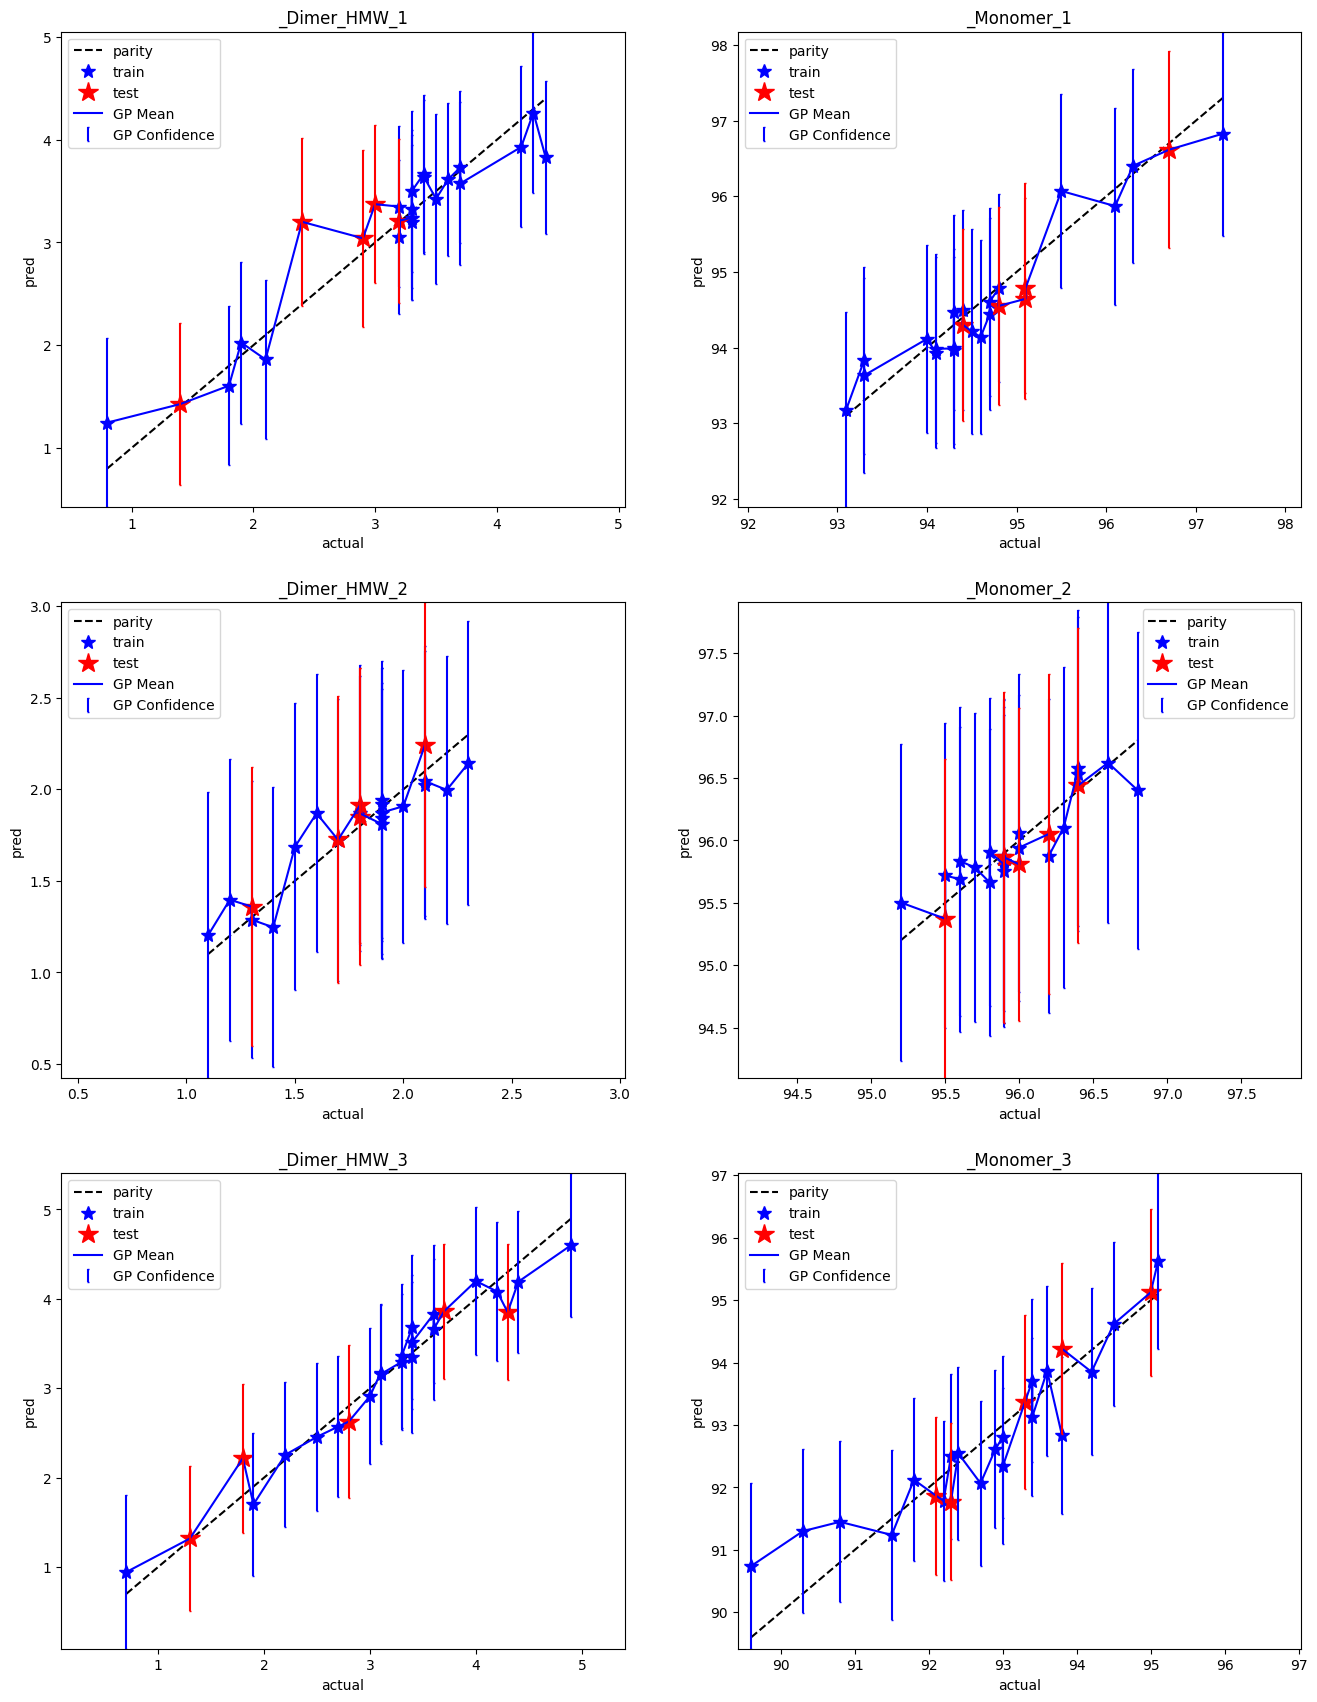

In [30]:
from sklearn.metrics import mean_squared_error

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_new = ['_Dimer_HMW_1', '_Monomer_1',
       '_Dimer_HMW_2', '_Monomer_2', 
       '_Dimer_HMW_3','_Monomer_3']

plot_axis_lb = total_df_y_long.min(axis = 0) - 0.4 * total_df_y_long.std(axis = 0)
plot_axis_ub = total_df_y_long.max(axis = 0) + 0.4 * total_df_y_long.std(axis = 0)

#num_outputs = arr_train_y.shape[-1]
#num_tasks = len(np.unique(arr_train_x[..., -1]))
num_outputs = len(cols_target)
#num_tasks = 3

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_new[a]

    r_train_y = arr_train_y[arr_train_x[:,-1]==task_ind,j]
    r_train_mean_y =arr_train_mean[arr_train_x[:,-1]==task_ind,j]
    r_train_lower_y =arr_train_lower[arr_train_x[:,-1]==task_ind,j]
    r_train_upper_y =arr_train_upper[arr_train_x[:,-1]==task_ind,j]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[arr_test_x[:,-1]==task_ind,j]
    r_test_mean_y =arr_test_mean[arr_test_x[:,-1]==task_ind,j]
    r_test_lower_y =arr_test_lower[arr_test_x[:,-1]==task_ind,j]
    r_test_upper_y =arr_test_upper[arr_test_x[:,-1]==task_ind,j]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])
    else:
      arr_comp = df_comp[df_comp.columns.difference(['mode'])].to_numpy()
      axis_max = arr_comp.max()
      axis_min = arr_comp.min()
      y_axes[a].set_xlim([axis_min,axis_max])
      y_axes[a].set_ylim([axis_min,axis_max])

    y_axes[a].legend(['parity','train','test','GP Mean','GP Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std)/np.mean(y_true),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std)/np.mean(y_train),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD_PCT','MIN_STD_PCT','MAX_STD_PCT'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD_PCT','MIN_STD_PCT','MAX_STD_PCT'])
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

In [ ]:
import itertools
num_total_output = 6
n_cv = 5
num_cols = num_total_output*n_cv

In [ ]:
#def set_up_mtmo_cv(self):
if True:
        ls_model_from_combs = []

        ls_lr = [0.1,0.15,0.25]#[0.1,0.15,0.2,0.25,0.3,0.35,0.40]
        ls_n_iter = [500,700,900,1100]#[200,300,400,500,700]
        combs = list(itertools.product(ls_lr,ls_n_iter))

        mean_arr_cv_mae = np.zeros((2,len(combs))) #train,test
        mean_arr_cv_r2 = np.zeros((2,len(combs))) #train,test
        mean_arr_cv_err = np.zeros((2,len(combs))) #train,test

        ls_arr_cv_mae = [np.zeros((2,len(combs))) for _ in range(num_total_output)]
        ls_arr_cv_r2 = [np.zeros((2,len(combs))) for _ in range(num_total_output)]
        ls_arr_cv_err = [np.zeros((2,len(combs))) for _ in range(num_total_output)]

        for i in range(0,len(combs)):
            lr,n_iter = combs[i]
            arr_train_metrics = np.zeros((11,num_cols))
            arr_test_metrics = np.zeros((11,num_cols))
            pre_model = None
            for batch_ind in range(n_cv):
                t_train_x = ls_X_train[batch_ind]
                t_train_y = ls_y_train[batch_ind]
                t_test_x = ls_X_test[batch_ind]
                t_test_y = ls_y_test[batch_ind]

                likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                    num_tasks=self.num_outputs, 
                    rank=self.link_rank if self.link_rank is not None else 0,
                )
                model = MTMOGP(t_train_x, t_train_y,likelihood,
                               task_rank = self.num_tasks,output_rank = self.num_outputs)

                if batch_ind>0:
                    source_state_dict = pre_model.state_dict()
                    model.load_state_dict(source_state_dict)
                # Find optimal model hyperparameters
                model.train()
                likelihood.train()

                # Use the adam optimizer
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

                # "Loss" for GPs - the marginal log likelihood
                mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

                training_iterations = n_iter#500
                for _ in range(training_iterations):
                    optimizer.zero_grad()
                    output = model(t_train_x)
                    loss = -mll(output, t_train_y)
                    loss.backward()
                    #print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
                    optimizer.step()

                ls_model_from_combs.append(model)
                if batch_ind == 0:
                    pre_model = model

                # Set into eval mode
                model.eval()
                likelihood.eval()

                arr_train_x = t_train_x.detach().numpy()
                arr_test_x = t_test_x.detach().numpy()
                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                    test_pred = likelihood(model(t_test_x))   
                    test_mean = test_pred.mean
                    test_lower, test_upper = test_pred.confidence_region()
                    train_pred = likelihood(model(t_train_x))
                    train_mean = train_pred.mean
                    train_lower, train_upper = train_pred.confidence_region()
    
                if self.y_scale=='no-y-scale':
                    arr_train_y = t_train_y.detach().numpy()
                    arr_test_y = t_test_y.detach().numpy()
                    arr_test_mean = test_mean.detach().numpy()
                    arr_test_lower = test_lower.detach().numpy()
                    arr_test_upper = test_upper.detach().numpy()

                    arr_train_mean = train_mean.detach().numpy()
                    arr_train_lower = train_lower.detach().numpy()
                    arr_train_upper = train_upper.detach().numpy()
                else:
                    y_scaler = self.obj_y_scaler[batch_ind]
                    arr_train_y = y_scaler.inverse_transform(t_train_y)
                    arr_test_y = t_test_y.detach().numpy()

                    arr_train_mean = y_scaler.inverse_transform(train_mean)
                    arr_train_lower = y_scaler.inverse_transform(train_lower)
                    arr_train_upper = y_scaler.inverse_transform(train_upper)

                    arr_test_mean = y_scaler.inverse_transform(test_mean)
                    arr_test_lower = y_scaler.inverse_transform(test_lower)
                    arr_test_upper = y_scaler.inverse_transform(test_upper)

                for task_ind in range(self.num_tasks):
                    for j in range(self.num_outputs):
                        mtmo_ind = j + self.num_outputs*task_ind
                        row_train_inds = arr_train_x[:,-1]==task_ind
                        r_train_y = arr_train_y[row_train_inds,j]
                        r_train_mean_y =arr_train_mean[row_train_inds,j]
                        r_train_lower_y =arr_train_lower[row_train_inds,j]
                        r_train_upper_y =arr_train_upper[row_train_inds,j]
                        r_train_std = r_train_mean_y - r_train_lower_y

                        row_test_inds = arr_test_x[:,-1]==task_ind
                        r_test_y = arr_test_y[row_test_inds,j]
                        r_test_mean_y =arr_test_mean[row_test_inds,j]
                        r_test_lower_y =arr_test_lower[row_test_inds,j]
                        r_test_upper_y =arr_test_upper[row_test_inds,j]
                        r_test_std = r_test_mean_y - r_test_lower_y
    
                        train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
                        df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
                        df_train_comp['upper'] = r_train_upper_y
                        df_train_comp['lower'] = r_train_lower_y
                        df_train_comp['mode'] = 'train'
    
                        test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
                        df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
                        df_test_comp['upper'] = r_test_upper_y
                        df_test_comp['lower'] = r_test_lower_y
                        df_test_comp['mode'] = 'test'

                        y_true = r_test_y
                        y_pred = r_test_mean_y
                        y_train = r_train_y
                        mean_train = r_train_mean_y
    
                        a = batch_ind + self.n_cv*mtmo_ind
                        #a = mtmo_ind + self.num_total_output*batch_ind
                        arr_test_metrics[0,a] = metrics.mean_absolute_error(y_true, y_pred)
                        arr_test_metrics[1,a] = metrics.median_absolute_error(y_true, y_pred)
                        arr_test_metrics[2,a] = metrics.mean_squared_error(y_true, y_pred)
                        arr_test_metrics[3,a] = metrics.root_mean_squared_error(y_true, y_pred)
                        arr_test_metrics[4,a] = metrics.mean_absolute_percentage_error(y_true, y_pred)
                        arr_test_metrics[5,a] = metrics.max_error(y_true, y_pred)
                        arr_test_metrics[6,a] = metrics.explained_variance_score(y_true, y_pred)
                        arr_test_metrics[7,a] = metrics.r2_score(y_true, y_pred)
                        arr_test_metrics[8,a] = np.mean(r_test_std)
                        arr_test_metrics[9,a] = np.min(r_test_std)
                        arr_test_metrics[10,a] = np.max(r_test_std)

                        arr_train_metrics[0,a] = metrics.mean_absolute_error(y_train, mean_train)
                        arr_train_metrics[1,a] = metrics.median_absolute_error(y_train, mean_train)
                        arr_train_metrics[2,a] = metrics.mean_squared_error(y_train, mean_train)
                        arr_train_metrics[3,a] = metrics.root_mean_squared_error(y_train, mean_train)
                        arr_train_metrics[4,a] = metrics.mean_absolute_percentage_error(y_train, mean_train)
                        arr_train_metrics[5,a] = metrics.max_error(y_train, mean_train)
                        arr_train_metrics[6,a] = metrics.explained_variance_score(y_train, mean_train)
                        arr_train_metrics[7,a] = metrics.r2_score(y_train, mean_train)
                        arr_train_metrics[8,a] = np.mean(r_train_std)
                        arr_train_metrics[9,a] = np.min(r_train_std)
                        arr_train_metrics[10,a] = np.max(r_train_std)
                        arr_train_metrics[8,a] = np.mean(r_train_std)
                        arr_train_metrics[9,a] = np.min(r_train_std)
                        arr_train_metrics[10,a] = np.max(r_train_std)
      
                        ls_arr_cv_mae[mtmo_ind][0,i] = np.mean(arr_train_metrics[0,self.n_cv*mtmo_ind:self.n_cv*(mtmo_ind+1)])
                        ls_arr_cv_mae[mtmo_ind][1,i] = np.mean(arr_test_metrics[0,self.n_cv*mtmo_ind:self.n_cv*(mtmo_ind+1)])

                        ls_arr_cv_r2[mtmo_ind][0,i] = np.mean(arr_train_metrics[6,self.n_cv*mtmo_ind:self.n_cv*(mtmo_ind+1)])
                        ls_arr_cv_r2[mtmo_ind][1,i] = np.mean(arr_test_metrics[6,self.n_cv*mtmo_ind:self.n_cv*(mtmo_ind+1)])

                        ls_arr_cv_err[mtmo_ind][0,i] = np.mean(arr_train_metrics[8,self.n_cv*mtmo_ind:self.n_cv*(mtmo_ind+1)])
                        ls_arr_cv_err[mtmo_ind][1,i] = np.mean(arr_test_metrics[8,self.n_cv*mtmo_ind:self.n_cv*(mtmo_ind+1)])

            mean_arr_cv_mae[0,i] = np.mean(arr_train_metrics[0,:])
            mean_arr_cv_mae[1,i] = np.mean(arr_test_metrics[0,:])

            mean_arr_cv_r2[0,i] = np.mean(arr_train_metrics[6,:])
            mean_arr_cv_r2[1,i] = np.mean(arr_test_metrics[6,:])

            mean_arr_cv_err[0,i] = np.mean(arr_train_metrics[8,:])
            mean_arr_cv_err[1,i] = np.mean(arr_test_metrics[8,:])


        #return combs,ls_model_from_combs,ls_arr_cv_mae,ls_arr_cv_r2,ls_arr_cv_err,mean_arr_cv_mae,mean_arr_cv_r2,mean_arr_cv_err